In [1]:
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm


In [7]:
def show(img, title="", cmap="gray", size=6):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

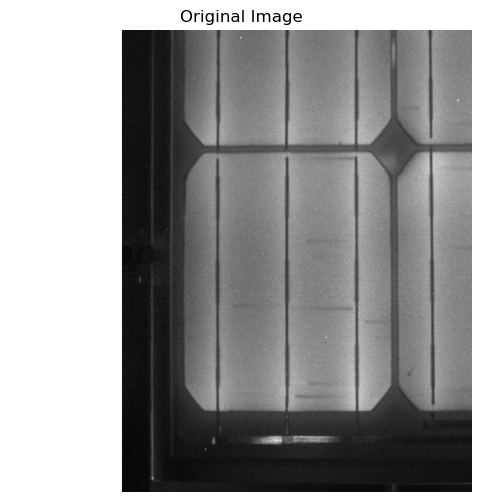

In [9]:
img = cv2.imread(r"D:\PROGRAMMING\Internships_assignments\ResearchInternIITMandi\dataset\dataset\ARTS_00007_r12_c1.png", 
                 cv2.IMREAD_GRAYSCALE)

show(img, "Original Image")

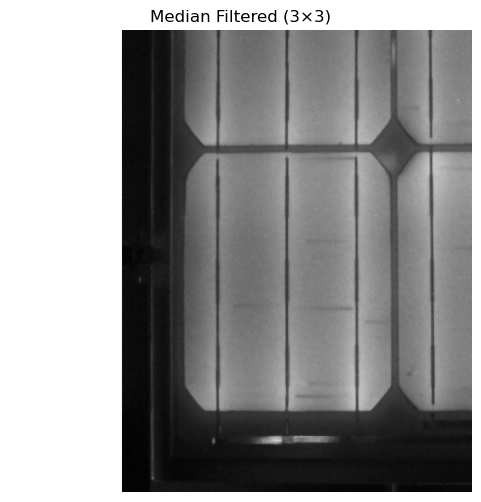

In [10]:
median = cv2.medianBlur(img, 3)
show(median, "Median Filtered (3×3)")


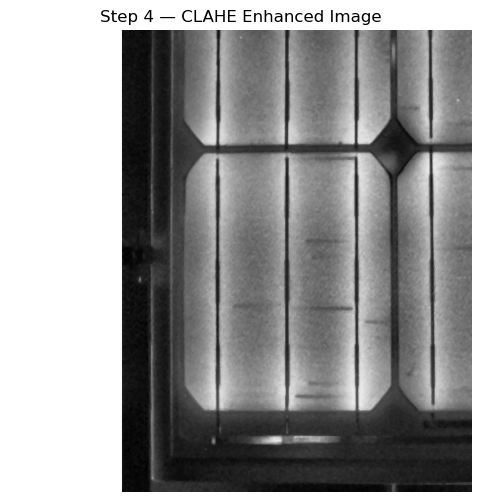

In [11]:
# Create CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Apply CLAHE on the median-filtered image
enhanced = clahe.apply(median)

# Show result
show(enhanced, "Step 4 — CLAHE Enhanced Image")


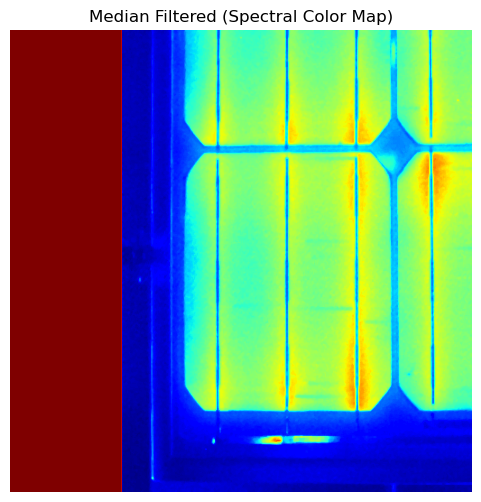

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(median, cmap="jet")
plt.title("Median Filtered (Spectral Color Map)")
plt.axis("off")
plt.show()

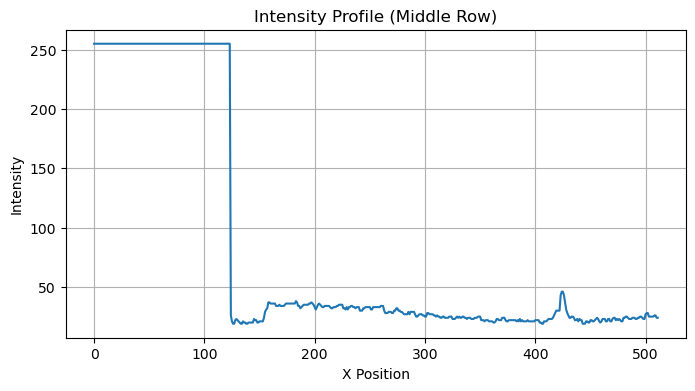

In [14]:
row = median.shape[0] - 1
profile = median[row, :]

plt.figure(figsize=(8,4))
plt.plot(profile)
plt.title("Intensity Profile (Middle Row)")
plt.xlabel("X Position")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

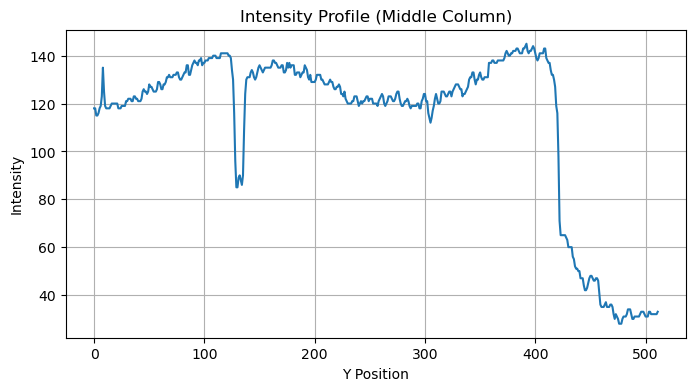

In [15]:
col = median.shape[1] // 2
profile = median[:, col]

plt.figure(figsize=(8,4))
plt.plot(profile)
plt.title("Intensity Profile (Middle Column)")
plt.xlabel("Y Position")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

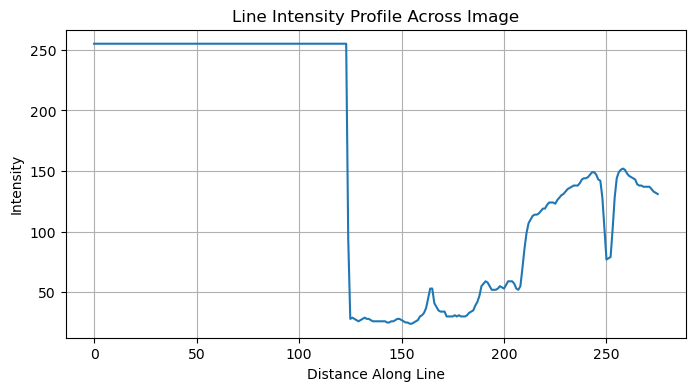

In [16]:
from skimage.measure import profile_line

p0 = (50, 20)   # start point (row, col)
p1 = (200, 250) # end point

profile = profile_line(median, p0, p1)

plt.figure(figsize=(8,4))
plt.plot(profile)
plt.title("Line Intensity Profile Across Image")
plt.xlabel("Distance Along Line")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

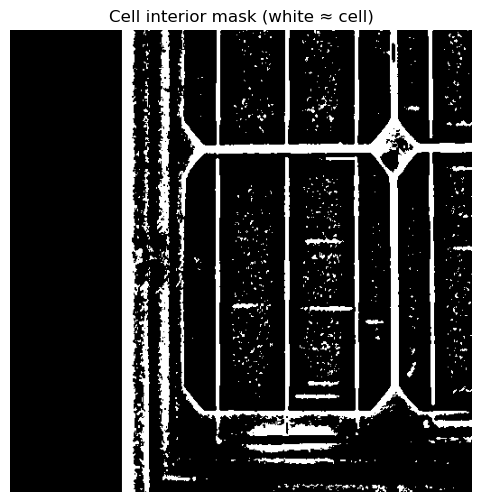

In [26]:
# Step A: Invert CLAHE so bright cell becomes white
enh_inv = cv2.bitwise_not(enhanced)

# Step B: Adaptive threshold on inverted image
cell_mask = cv2.adaptiveThreshold(
    enh_inv,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    51,
    -10
)

show(cell_mask, "Cell interior mask (white ≈ cell)")


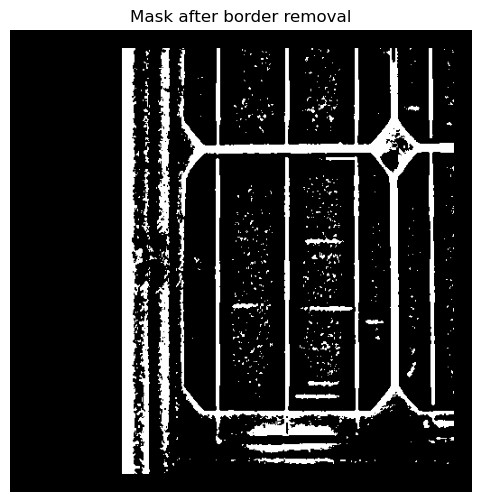

In [27]:
# Step C — Remove borders (prevent contour touching edges)
h, w = cell_mask.shape
border = 20
cell_mask[0:border, :] = 0
cell_mask[h-border:h, :] = 0
cell_mask[:, 0:border] = 0
cell_mask[:, w-border:w] = 0

show(cell_mask, "Mask after border removal")


In [28]:
contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = [(cv2.contourArea(c), c) for c in contours]
areas.sort(reverse=True)

best_cnt = areas[0][1]

cnt_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(cnt_vis, [best_cnt], -1, (0,255,0), 2)
show(cnt_vis, "Correct Cell Contour (no image borders)")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

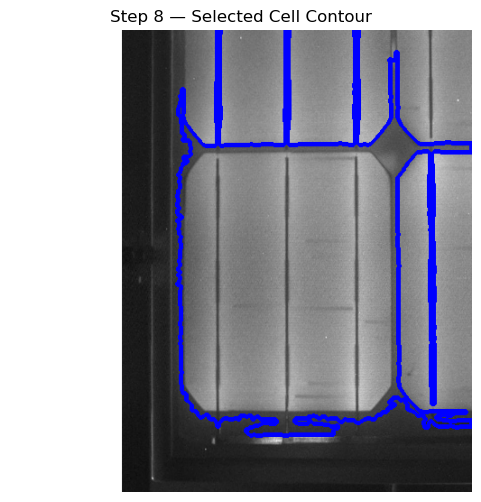

In [24]:
img_area = h * w
candidates = []

for c in contours:
    area = cv2.contourArea(c)
    if area < 0.03 * img_area:  # remove tiny objects
        continue

    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)

    solidity = area / hull_area if hull_area > 0 else 0
    rect = cv2.minAreaRect(c)
    w_rect, h_rect = rect[1]

    if w_rect == 0 or h_rect == 0:
        continue

    # aspect ratio close to rectangular (solar cells often 0.7–1.8)
    ar = min(w_rect, h_rect) / max(w_rect, h_rect)

    # scoring: rectangular and solid is better
    score = solidity * ar * area
    candidates.append((score, c))

# pick best contour
best_cnt = max(candidates, key=lambda x: x[0])[1]

# visualize best contour
best_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(best_vis, [best_cnt], -1, (0,0,255), 3)

show(best_vis, "Step 8 — Selected Cell Contour")


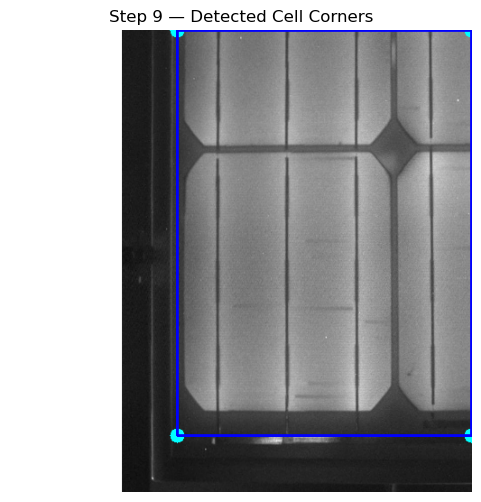

In [25]:
# STEP 9 — Approximate the best contour to a polygon

# Calculate perimeter
peri = cv2.arcLength(best_cnt, True)

# Try to approximate the contour to 4 points
approx = cv2.approxPolyDP(best_cnt, 0.02 * peri, True)

if len(approx) == 4:
    pts = approx.reshape(4,2).astype(np.float32)
else:
    # fallback: use the minimum-area rectangle
    rect = cv2.minAreaRect(best_cnt)
    pts = cv2.boxPoints(rect).astype(np.float32)

# Visualize the 4 corner points
corner_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for p in pts:
    cv2.circle(corner_vis, (int(p[0]), int(p[1])), 8, (0,255,255), -1)

cv2.polylines(corner_vis, [pts.astype(np.int32)], True, (0,0,255), 2)

show(corner_vis, "Step 9 — Detected Cell Corners")
